In [11]:
"""
MetaRCWA Example 0
Single-interface Fresnel reflection/transmission versus incident angle.
"""
import sys
from pathlib import Path
import numpy as np
import torch
from matplotlib import pyplot as plt

sys.path.append(str(Path('..').resolve()))
from metaRCWA import MetaRCWA

# Hardware and numeric precision
torch.backends.cuda.matmul.allow_tf32 = False
SIM_DTYPE = torch.complex64
GEO_DTYPE = torch.float32
device = torch.device('cpu')

# Problem setup
wavelength_nm = 973.0
lattice_nm = [600.0, 600.0]
azi_angle = torch.tensor(0.0, dtype=SIM_DTYPE, device=device)
substrate_n = 3.53
background_n = 1.0
angles = torch.linspace(0.0, 15.0, 16, dtype=GEO_DTYPE, device=device) * (np.pi / 180.0)
orders = [7, 7]


In [12]:
def sweep_interface():
    r_tm, r_te, t_tm, t_te = [], [], [], []
    for theta in angles:
        solver = MetaRCWA(
            optical=1.0 / wavelength_nm,
            fourier_order=orders,
            cell_period=lattice_nm,
            precision={'dtype': SIM_DTYPE, 'device': device}
        )
        solver.configure_input_layer(eps=substrate_n ** 2)
        solver.configure_output_layer(eps=background_n ** 2)
        solver.set_incident_angles(theta.to(SIM_DTYPE), azi_angle)
        solver.solve_global_s_matrix()
        r_tm.append(solver.scattering_parameters([[0, 0]], direction='forward', port='reflection', polarization='pp'))
        r_te.append(solver.scattering_parameters([[0, 0]], direction='forward', port='reflection', polarization='ss'))
        t_tm.append(solver.scattering_parameters([[0, 0]], direction='forward', port='transmission', polarization='pp'))
        t_te.append(solver.scattering_parameters([[0, 0]], direction='forward', port='transmission', polarization='ss'))
    return torch.cat(r_tm), torch.cat(r_te), torch.cat(t_tm), torch.cat(t_te)

r_tm, r_te, t_tm, t_te = sweep_interface()


In [13]:
theta = angles.to(SIM_DTYPE)
n1 = substrate_n
n2 = background_n

R_TM_analytic = torch.abs((n1 * torch.sqrt(1 - (n1 / n2 * torch.sin(theta)) ** 2) - n2 * torch.cos(theta)) /
                          (n1 * torch.sqrt(1 - (n1 / n2 * torch.sin(theta)) ** 2) + n2 * torch.cos(theta))) ** 2
R_TE_analytic = torch.abs((n1 * torch.cos(theta) - n2 * torch.sqrt(1 - (n1 / n2 * torch.sin(theta)) ** 2)) /
                          (n1 * torch.cos(theta) + n2 * torch.sqrt(1 - (n1 / n2 * torch.sin(theta)) ** 2))) ** 2


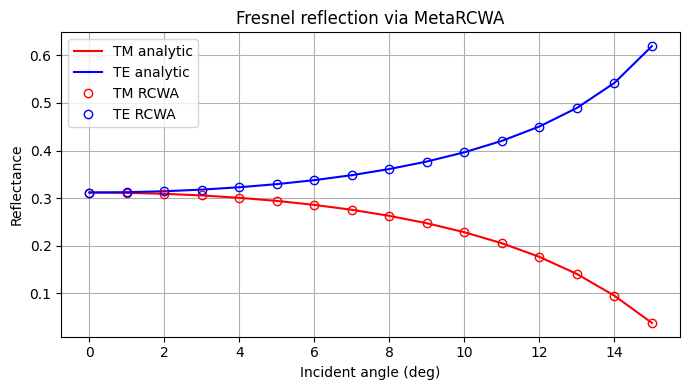

In [14]:
plt.figure(figsize=(7, 4))
plt.plot(angles.cpu() * 180 / np.pi, R_TM_analytic.cpu(), 'r', label='TM analytic')
plt.plot(angles.cpu() * 180 / np.pi, R_TE_analytic.cpu(), 'b', label='TE analytic')
plt.plot(angles.cpu() * 180 / np.pi, torch.abs(r_tm).cpu() ** 2, 'ro', fillstyle='none', label='TM RCWA')
plt.plot(angles.cpu() * 180 / np.pi, torch.abs(r_te).cpu() ** 2, 'bo', fillstyle='none', label='TE RCWA')
plt.xlabel('Incident angle (deg)')
plt.ylabel('Reflectance')
plt.title('Fresnel reflection via MetaRCWA')
plt.grid(True)
plt.legend()
plt.tight_layout()


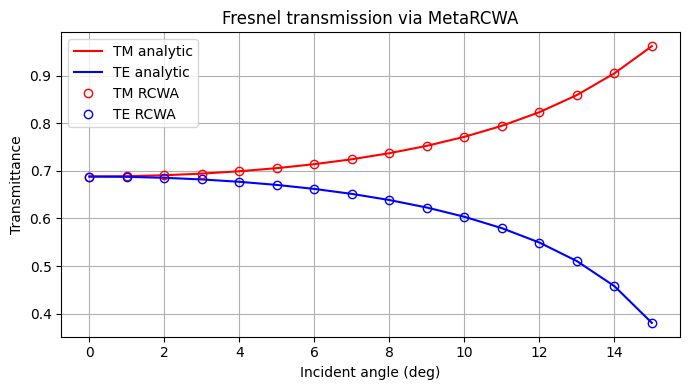

In [15]:
plt.figure(figsize=(7, 4))
plt.plot(angles.cpu() * 180 / np.pi, 1 - R_TM_analytic.cpu(), 'r', label='TM analytic')
plt.plot(angles.cpu() * 180 / np.pi, 1 - R_TE_analytic.cpu(), 'b', label='TE analytic')
plt.plot(angles.cpu() * 180 / np.pi, torch.abs(t_tm).cpu() ** 2, 'ro', fillstyle='none', label='TM RCWA')
plt.plot(angles.cpu() * 180 / np.pi, torch.abs(t_te).cpu() ** 2, 'bo', fillstyle='none', label='TE RCWA')
plt.xlabel('Incident angle (deg)')
plt.ylabel('Transmittance')
plt.title('Fresnel transmission via MetaRCWA')
plt.grid(True)
plt.legend()
plt.tight_layout()
